In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [2]:
datadir = 'data_2'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

center  \
0  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\center_2021_05_07_18_44_21_531.jpg   
1  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\center_2021_05_07_18_44_21_633.jpg   
2  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\center_2021_05_07_18_44_21_736.jpg   
3  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\center_2021_05_07_18_44_21_839.jpg   
4  C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\center_2021_05_07_18_44_21_940.jpg   

                                                                                                                   left  \
0   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\left_2021_05_07_18_44_21_531.jpg   
1   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\left_2021_05_07_18_44_21_633.jpg   
2   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\left_2021_05_07_18_44_21_736.jpg   
3   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\left_2021_05_07_18_44_21_839.jpg   
4   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\left_2021_05_07_18_44_21_940.jpg   

                                                                                                                   right  \
0   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\right_2021_05_07_18_44_21_531.jpg   
1   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\right_2021_05_07_18_44_21_633.jpg   
2   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\right_2021_05_07_18_44_21_736.jpg   
3   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\right_2021_05_07_18_44_21_839.jpg   
4   C:\Users\sudharsan\Desktop\codes\python_programs\udemy_self_driving_car\data_2\IMG\right_2021_05_07_18_44_21_940.jpg   

   steering  throttle  reverse     speed  
0       0.0       0.0      0.0  0.000082  
1       0.0       0.0      0.0  0.000081  
2       0.0       0.0      0.0  0.000082  
3       0.0       0.0      0.0  0.000082  
4       0.0       0.0      0.0  0.000082

In [3]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2021_05_07_18_44_21_531.jpg  left_2021_05_07_18_44_21_531.jpg   
1  center_2021_05_07_18_44_21_633.jpg  left_2021_05_07_18_44_21_633.jpg   
2  center_2021_05_07_18_44_21_736.jpg  left_2021_05_07_18_44_21_736.jpg   
3  center_2021_05_07_18_44_21_839.jpg  left_2021_05_07_18_44_21_839.jpg   
4  center_2021_05_07_18_44_21_940.jpg  left_2021_05_07_18_44_21_940.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_05_07_18_44_21_531.jpg       0.0       0.0      0.0  0.000082  
1  right_2021_05_07_18_44_21_633.jpg       0.0       0.0      0.0  0.000081  
2  right_2021_05_07_18_44_21_736.jpg       0.0       0.0      0.0  0.000082  
3  right_2021_05_07_18_44_21_839.jpg       0.0       0.0      0.0  0.000082  
4  right_2021_05_07_18_44_21_940.jpg       0.0       0.0      0.0  0.000082

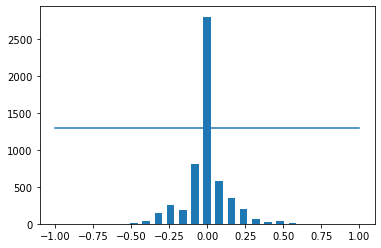

In [4]:
num_bins = 25
samples_per_bin = 1300
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))


total data 5537
removed 1504
remaining 4033


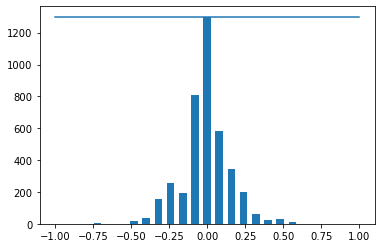

In [5]:
print('total data', len(data))

remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
    
print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))

In [6]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2021_05_07_18_44_22_044.jpg
left          left_2021_05_07_18_44_22_044.jpg
right        right_2021_05_07_18_44_22_044.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                              8.17742e-05
Name: 5, dtype: object


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 9679
Valid Samples: 2420


Text(0.5, 1.0, 'Validation set')

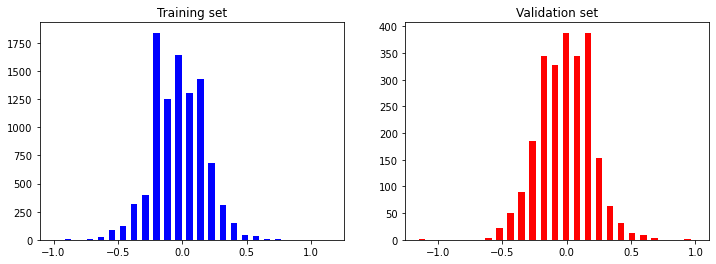

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [9]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1.0, 'Zoomed Image')

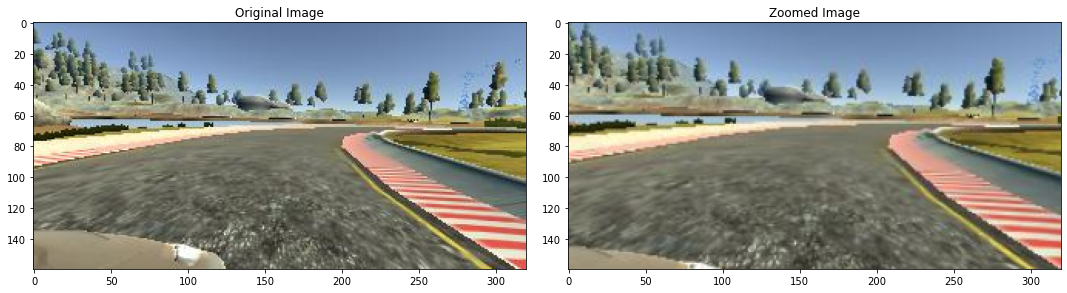

In [10]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [11]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


Text(0.5, 1.0, 'Panned Image')

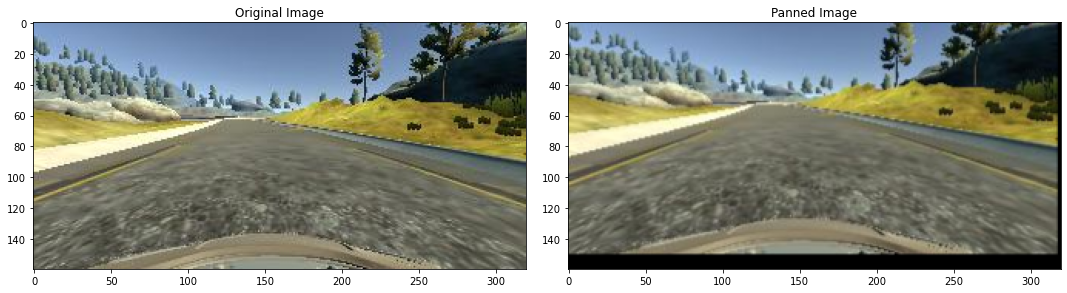

In [12]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [13]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.4, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

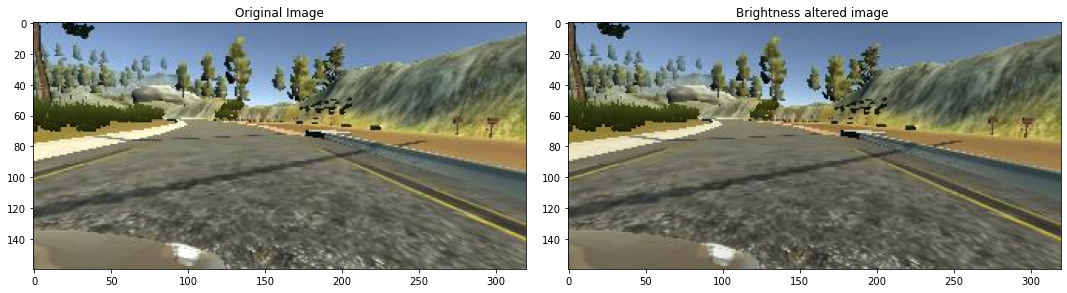

In [14]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [15]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1) # one for horizontal flip
    steering_angle =- steering_angle
    return image,steering_angle

Text(0.5, 1.0, 'flipped img: 0.009482252')

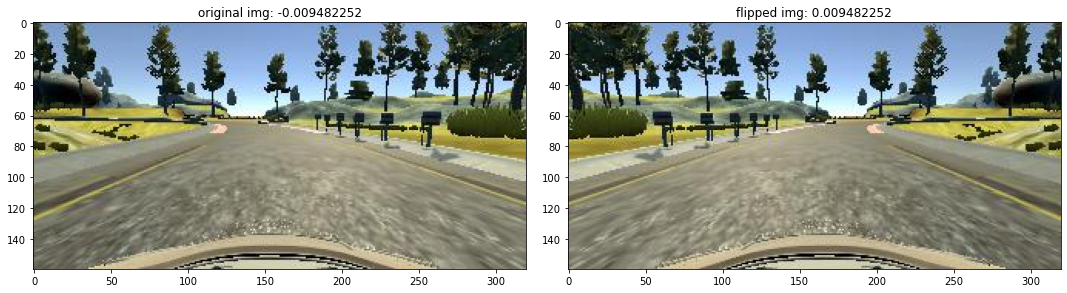

In [16]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axes = plt.subplots(1,2,figsize = (15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('original img: '+ str(steering_angle))

axes[1].imshow(flipped_image)
axes[1].set_title('flipped img: '+ str(flipped_steering_angle))

In [17]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

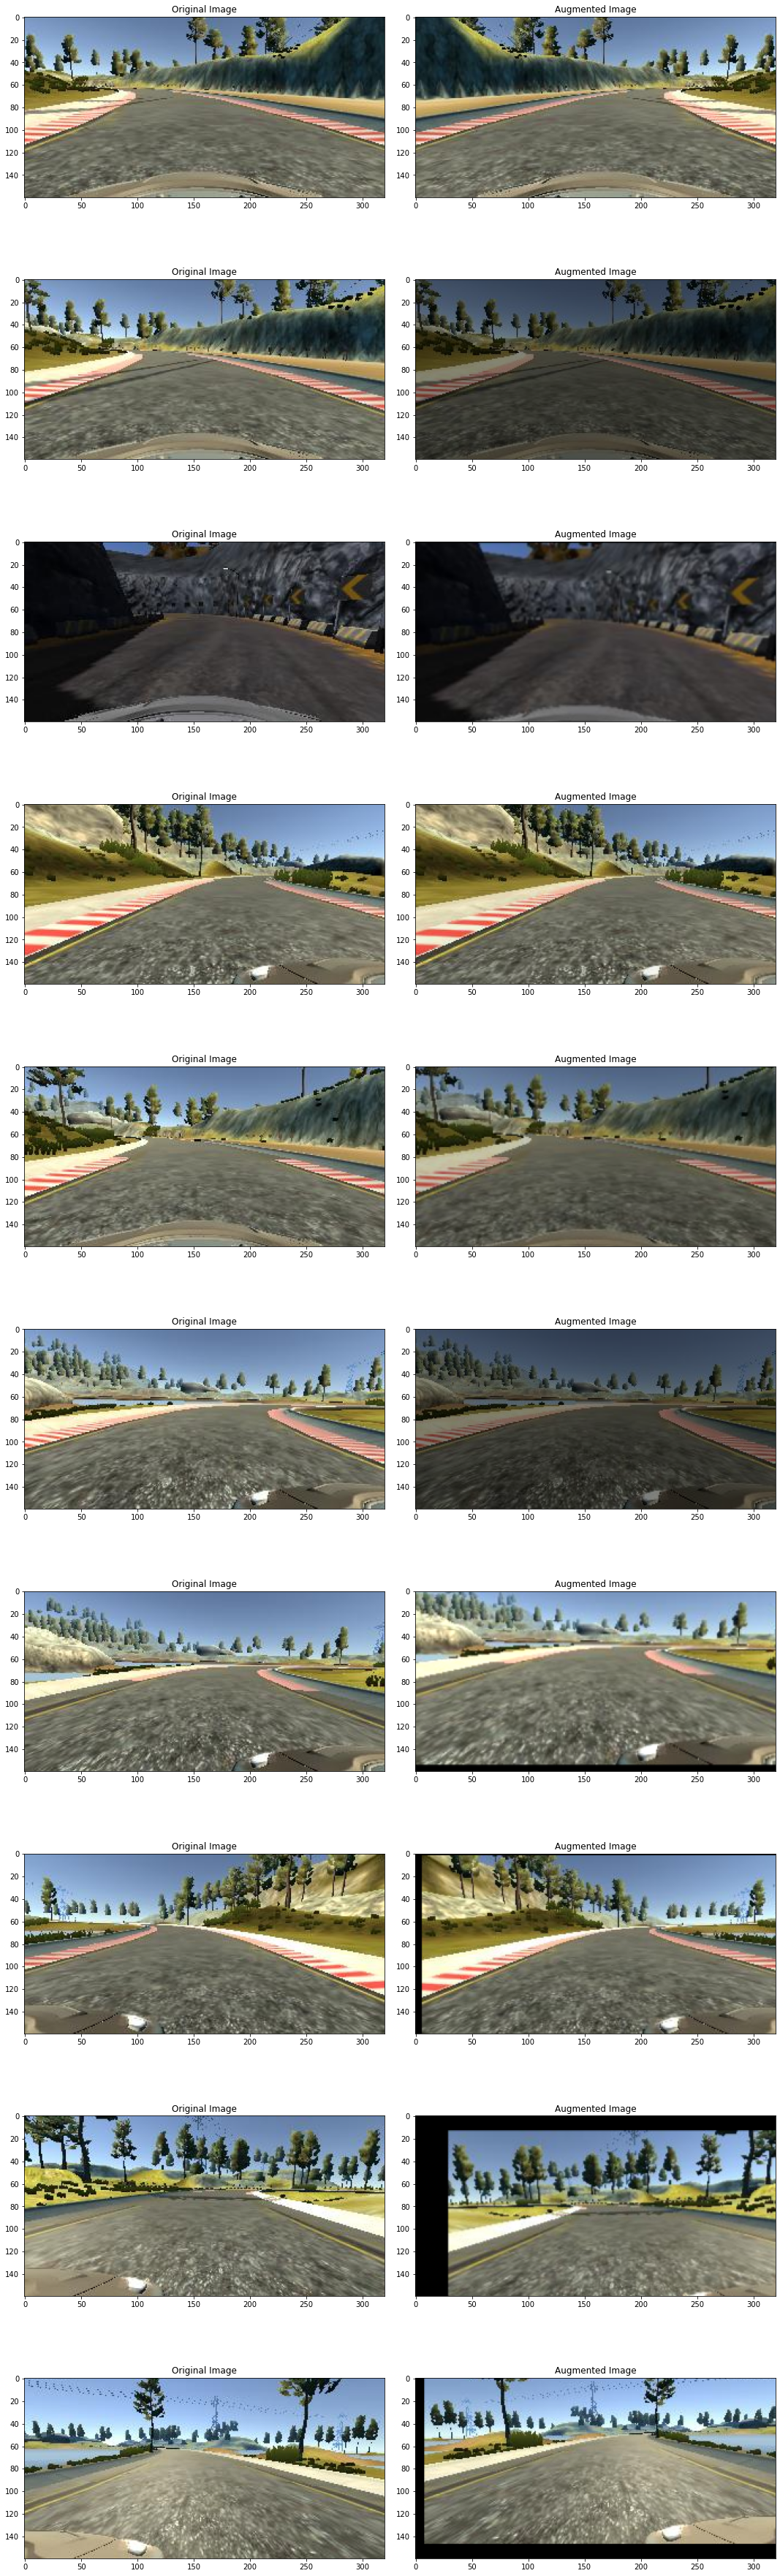

In [18]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [19]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

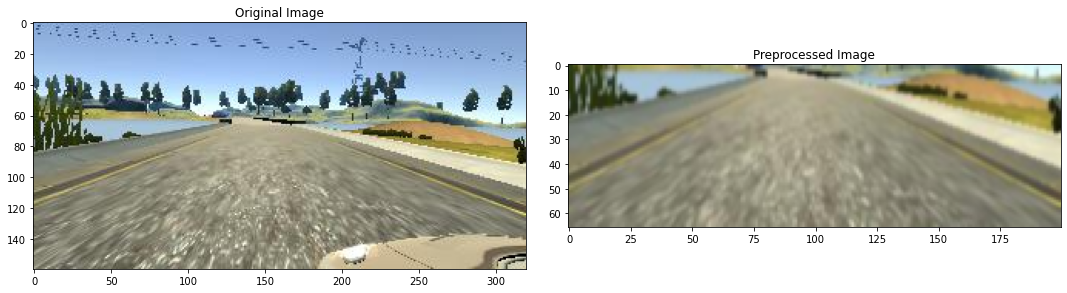

In [20]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [21]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
    while True:
        batch_img = []
        batch_steering = []
    
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
      
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
      
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation Image')

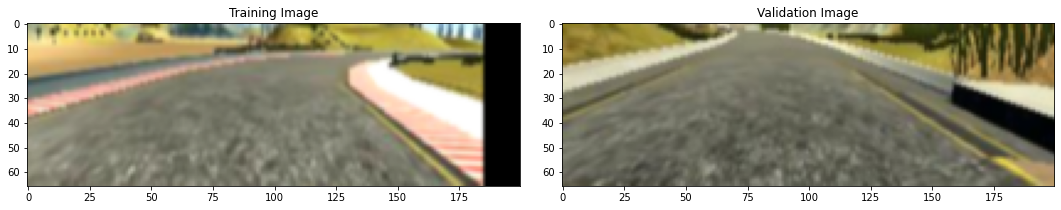

In [22]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [32]:
def nvidia_model():
 
    model = Sequential()
 
    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
 
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Dropout(0.45))
 
 
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.4))
 
 
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
 
 
    optimizer= Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
 
    return model

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten

#load model without dense layers
model = VGG16(include_top=False, weights=None, input_shape=(66,200,3))

# Add new classification layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation = "elu", )(flat1)
dropout = Dropout(0.3)(class1)
class2 = Dense(20, activation = "elu")(dropout)
output = Dense(1,)(class2)

# Define new model
model = Model(inputs=model.input, outputs=output)
model.compile(loss="mse", optimizer = "adam", metrics=["accuracy"])

# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 66, 200, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 66, 200, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 66, 200, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 33, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 33, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 33, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 50, 128)       0     

In [24]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = "val_loss", mode="auto",verbose=1,patience=2)

In [25]:
import tensorboard
import datetime

log_directory= "logs\\fit"

#timestamp = datetime.datetime.now().strftime("%y-%m-%d-%H:%M")
#log_directory = log_directory+"\\"+timestamp

#board = tensorflow.keras.callbacks.TensorBoard(log_dir = log_directory,histogram_freq=1,write_graph = True,
#                    write_images=True,update_freq="epoch",profile_batch=2)

board = tensorflow.keras.callbacks.TensorBoard(log_dir = log_directory,histogram_freq=1,write_graph = True,
                    write_images=True,update_freq="epoch")

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/18
200/200 [==============================] - 3034s 15s/step - loss: 0.0566 - accuracy: 0.0829 - val_loss: 0.0400 - val_accuracy: 0.0819
Epoch 2/18
200/200 [==============================] - 2958s 15s/step - loss: 0.0387 - accuracy: 0.0815 - val_loss: 0.0391 - val_accuracy: 0.0851
Epoch 3/18
200/200 [==============================] - 2878s 14s/step - loss: 0.0388 - accuracy: 0.0866 - val_loss: 0.0395 - val_accuracy: 0.0834
Epoch 4/18
200/200 [==============================] - 2772s 14s/step - loss: 0.0390 - accuracy: 0.0831 - val_loss: 0.0391 - val_accuracy: 0.0838
Epoch 00004: early stopping


Text(0.5, 0, 'Epoch')

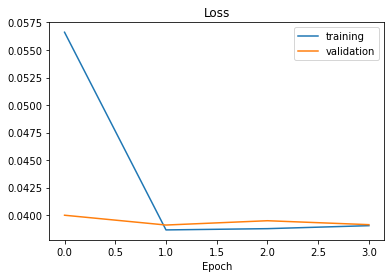

In [26]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=200, 
                                  epochs=18,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1, callbacks = [early_stop,board])

model.save('behaviour_cloning/model4.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')